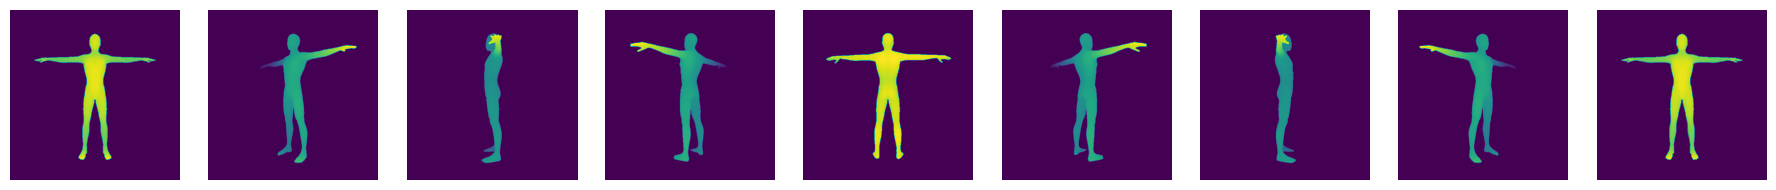

In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map
import torch

torch.set_grad_enabled(False)

animation_tag = 'mixamo-human_rotation:latest'
animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)

verts_uvs, faces_uvs = animation.uv_data()

n_frames = 9
frame_indices = animation.frame_indices(9)
cameras, meshes = animation.load_frames(frame_indices)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

In [4]:
from text3d2video.backprojection import project_visible_texels_to_camera

texture_res = 64

frame_texel_xys = []
frame_texel_uvs = []
for render_cams, render_meshes in zip(cameras, meshes):
    xys, uvs = project_visible_texels_to_camera(
        render_meshes, render_cams, verts_uvs, faces_uvs, texture_res
    )
    frame_texel_xys.append(xys.cpu())
    frame_texel_uvs.append(uvs.cpu())

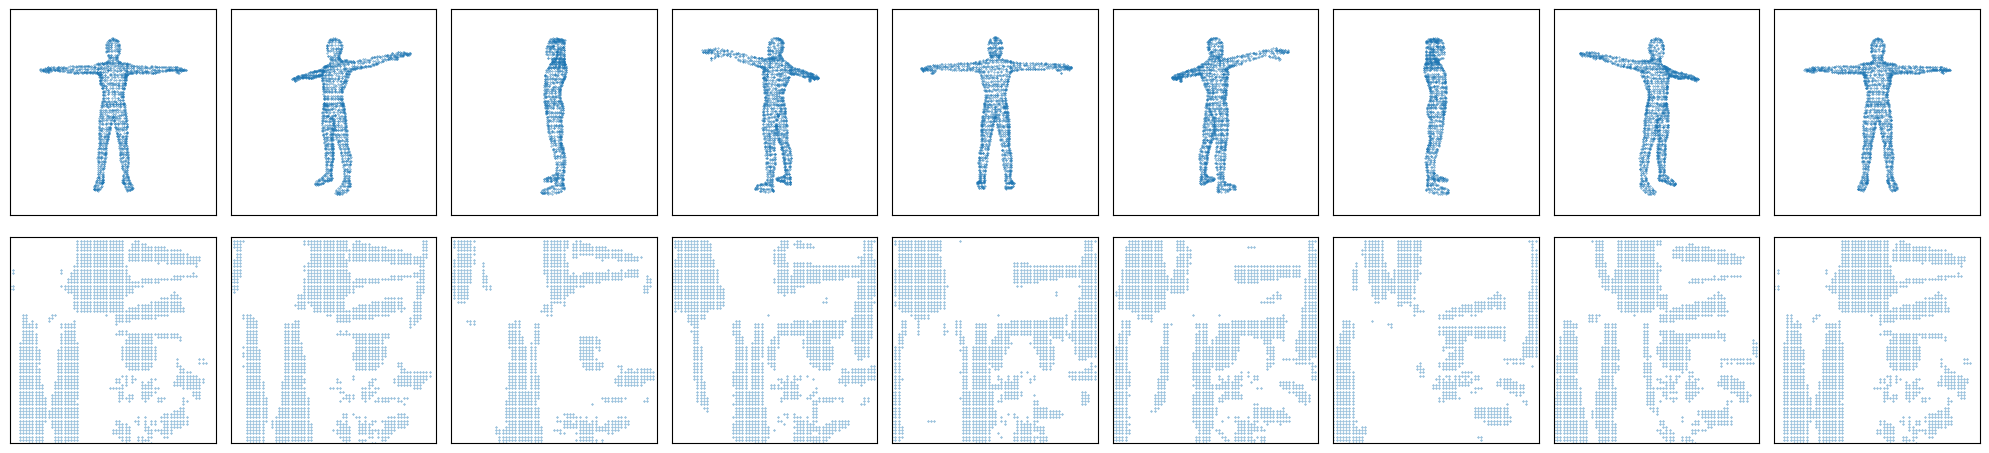

In [5]:
from matplotlib import pyplot as plt

s = 0.1

fig, axs = plt.subplots(2, len(meshes), figsize=(20, 5))
for i, (xy_coords, uv_coords) in enumerate(zip(frame_texel_xys, frame_texel_uvs)):
    ax_cam = axs[0, i]
    ax_uv = axs[1, i]

    ax_cam.scatter(xy_coords[:, 0].cpu(), xy_coords[:, 1].cpu(), s=s)

    ax_uv.scatter(uv_coords[:, 0].cpu(), uv_coords[:, 1].cpu(), s=s)

    ax_uv.set_aspect("equal")
    ax_uv.set_xlim(0, texture_res)
    ax_uv.set_ylim(0, texture_res)

    ax_cam.set_xlim(-1, 1)
    ax_cam.set_ylim(-1, 1)
    ax_cam.set_aspect("equal")

    ax_uv.set_xticks([])
    ax_uv.set_yticks([])
    ax_cam.set_xticks([])
    ax_cam.set_yticks([])

plt.tight_layout()

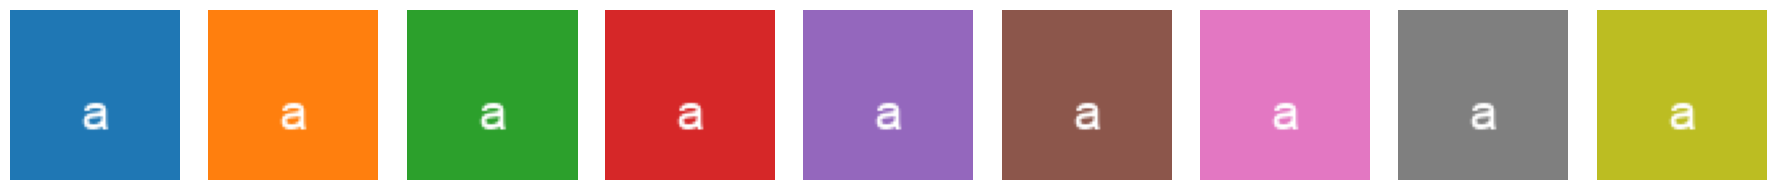

In [6]:
from matplotlib.cm import get_cmap
import torchvision.transforms.functional as TF
from visual_tests.testing_utils import test_img

CAMERA_RES = 64

cmap = get_cmap("tab10")

indices = torch.arange(n_frames)
colors = cmap(indices)

features_cond = [
    test_img(resolution=CAMERA_RES, color=colors[i][0:3], txt="a")
    for i in range(n_frames)
]
feature_maps = torch.stack([TF.to_tensor(img) for img in features_cond])

display_ims(features_cond)

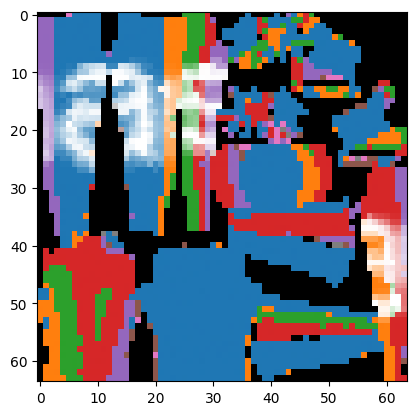

In [7]:
# frame_xy_coords
# frame_uv_coords

from text3d2video.backprojection import aggregate_views_uv_texture


uv_map = aggregate_views_uv_texture(
    feature_maps,
    texture_res,
    frame_texel_xys,
    frame_texel_uvs,
)

plt.imshow(uv_map.cpu())
